# How does TMDL grandfathering affect NPDES limit values?
The hypothesis driving this exploration is that facilities built on water bodies prior to TMDLs being created on those water bodies may be assigned *less* responsibility to reduce discharges (i.e., higher NPDES limits), when compared to facilities built after TMDLs are established (in essence, their old limits may be 'grandfathered' in post-TMDL).

In a prior version of this exploration, I looked into whether limit values on permits issued prior to TMDLs are lower than limit values on permits issued post-TMDL (irrespective of facility age), and found inconclusive results.

Author: Ryan Treves

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [173]:
# Load ATTAINS & RAD data
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object}).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})

# Load ICIS-NPDES permit data
permit_data = pd.read_csv('permit_data.csv', parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date', 'expiration_date', 'retirement_date', 'termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [3]:
# Link TMDLs to HUC-12 codes to NPDES permittees
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')

# Filter down to point-source TMDLs
tmdls_merged = tmdls_merged[tmdls_merged['pollutantSourceTypeCode'] != 'Nonpoint source']

# Deleting objects we no longer need to save memory
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

In [177]:
tmdls_merged['pollutantName'].value_counts()

IRON                                                            1551350
ALUMINUM                                                        1486115
MANGANESE                                                       1395822
PH                                                               905329
SEDIMENT                                                         601937
POLYCHLORINATED BIPHENYLS (PCBS)                                 262655
ESCHERICHIA COLI (E. COLI)                                       233548
PHOSPHORUS                                                       208988
FECAL COLIFORM                                                   192532
CHLORDANE                                                        181370
PHOSPHORUS, TOTAL                                                147802
NITROGEN, TOTAL                                                   99917
TOTAL SUSPENDED SOLIDS (TSS)                                      70937
MERCURY                                                         

Instead of looking at all TMDLs nationally at once, let's look at one pollutant at a time.
First, let's define a function to merge NPDES limits with TMDLs for a given parameter:

In [178]:
def merge_limits_tmdls(pollutant, dmr_path, permit_data, tmdl_data):
    # Read in DMR data for limit comparisons and drop rows with NA limit values
    dmrs = pd.read_csv(dmr_path, parse_dates=['limit_begin_date', 'limit_end_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).dropna(subset='limit_value_standard_units')

    # Extract only limits from DMR data
    limits = dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date', 'version_nmbr'])
    del dmrs

    # Merge with permit_data to get permit issuance date
    limits = limits.merge(permit_data, on=['npdes_permit_id', 'version_nmbr'], how='left')

    # Retain only TMDLs for the given parameter
    tmdl_data = tmdl_data[tmdl_data['pollutantName']==pollutant]
    # Merge limit data with TMDL data
    limits_merged = tmdl_data.merge(limits, on='npdes_permit_id', how='inner')

    # Drop limits that expired, retired, or were terminated before the TMDL date
    limits_merged = limits_merged[~(limits_merged['expiration_date'] <= limits_merged['TMDLDate']) &
                                              ~(limits_merged['retirement_date'] <= limits_merged['TMDLDate']) &
                                              ~(limits_merged['termination_date'] <= limits_merged['TMDLDate'])]
    # Define incumbency and old/new facility
    limits_merged['incumbent'] = (limits_merged['issue_date'] <= limits_merged['TMDLDate'])
    limits_merged['new_facility'] = (limits_merged['original_issue_date'] > limits_merged['TMDLDate'])

    return limits_merged

Next, let's define a function to test how different limit values are between new and old facilities of the same limit value type and base code within the same TMDL, for the same pollutant:

In [170]:
def test_facility_limit_diffs(limits):
    # Group by limit type
    grouped = limits.groupby(['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], as_index=False).nunique()

    # Only retain permit limit types with more than one permittee, as well as both new and old facilities
    grouped = grouped[(grouped['npdes_permit_id'] > 1) & (grouped['new_facility'] > 1)]
    all_stats = pd.DataFrame()

    for i in range(0, len(grouped)):
        # Pick out one permit limit type
        permit_limit_type = grouped.iloc[[i]][
            ['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier']].merge(limits,
                                        on=['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], how='inner')

        # Create ID tracking unique limits
        permit_limit_type['unique_lim_id'] = permit_limit_type['npdes_permit_id'] + '_' + permit_limit_type[
            'version_nmbr'].astype(str) + '_' + permit_limit_type['perm_feature_nmbr'].astype(str) + '_' + permit_limit_type['limit_begin_date'].astype(str)

        # Drop non-unique limits
        permit_limit_type.drop_duplicates('unique_lim_id', inplace=True)

        stats = permit_limit_type.groupby(['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier', 'new_facility'], as_index=False).agg(limit_mean=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.mean()), limit_mean_SE=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.sem()), unique_limits=pd.NamedAgg(column='unique_lim_id', aggfunc=lambda x: x.nunique()))
        stats = pd.pivot(stats, index=['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], columns='new_facility')
        stats.columns = ['Old_facility_limit_mean', 'New_facility_limit_mean', 'Old_facility_limit_SE', 'New_facility_limit_SE', 'Old_facility_unique_limits', 'New_facility_unique_limits']
        all_stats = pd.concat([all_stats, stats])
    return all_stats

### Phosphorus

In [179]:
# Merge limits with TMDLs and run difference test
P_limits_merged = merge_limits_tmdls('PHOSPHORUS, TOTAL', 'phosphorus_dmrs.csv', permit_data, tmdls_merged)
results = test_facility_limit_diffs(P_limits_merged)
results

Old_facility_limit_mean  \
pollutantName     limit_value_type_code statistical_base_code actionIdentifier                                              
PHOSPHORUS, TOTAL C1                    MB                    54424                                              2.578947   
                  C2                    AB                    53700                                              1.000000   
                                                              54424                                              1.000000   
                                        MK                    11567                                             20.328812   
                                                              30895                                              1.092000   
                                                              38283                                              0.391667   
                                                              40915                                              2.000000   
                                                              40917                                              2.000000   
                                                              40919                                              2.000000   
                                                              40947                                              0.650000   
                                                              40949                                              0.650000   
                                                              40951                                              0.650000   
                                                              41234                                              0.650000   
                                                              65982                                              1.257368   
                                                              67921                                              1.000000   
                                                              AL03160111_0303_102_Nutrients_2018                 5.000000   
                                                              MN_PRJ07671-002                                    1.000000   
                                                              MN_PRJ07720-001                                    0.876667   
                                        WA                    54424                                              2.047619   
                  C3                    DD                    30895                                              1.000000   
                                                              65982                                             10.000000   
                                        IA                    65220                                              0.189286   
                                        MK                    54424                                              1.368421   
                                        WA                    65982                                              1.491667   
                  Q1                    MK                    39366                                              1.900000   
                                                              40242                                              1.900000   
                                                              42340                                             38.977602   
                                                              53480                                              3.103090   
                                                              64283                                              1.900000   
                                                              65982                                              8.966250   
                                        QA                    31474                               

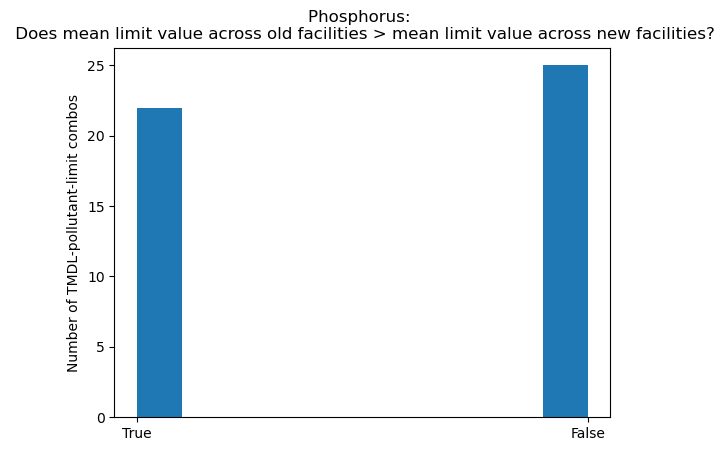

In [180]:
# Plot results
plt.style.use('default')
plt.title('Phosphorus: \n Does mean limit value across old facilities > mean limit value across new facilities?');
plt.ylabel('Number of TMDL-pollutant-limit combos')
plt.hist(list(map(str, results['Old_facility_limit_mean']>results['New_facility_limit_mean'])));

### Mercury

In [175]:
# Merge limits with TMDLs and run difference test
Hg_limits_merged = merge_limits_tmdls('MERCURY', 'mercury_dmrs.csv', permit_data, tmdls_merged)
results = test_facility_limit_diffs(Hg_limits_merged)
results

Old_facility_limit_mean  \
pollutantName limit_value_type_code statistical_base_code actionIdentifier                            
MERCURY       C2                    1D                    MI-2018-002                      0.000005   
                                    MK                    33994                            0.000948   
                                                          37909                            0.000400   
                                                          38859                            0.000040   
                                                          IL-2019-002                      0.000001   
              C3                    1D                    32414                            0.000007   
                                    DD                    11082                            0.000132   
                                                          11083                            0.000346   
                                                          33994                            0.004941   
                                                          37909                            0.009183   
                                                          38859                            0.000542   
                                                          IL-2019-002                      0.000003   
                                    MN                    MI-2018-002                     57.000000   
                                    QB                    32414                            0.000017   
              Q1                    1D                    MI-2018-002                      0.001260   
                                    MK                    37909                            0.029818   
                                                          IL-2019-002                      0.000403   
                                                          MI-2018-002                      0.000011   
              Q2                    DD                    37909                            0.073880   
                                                          IL-2019-002                      0.000990   

                                                                            New_facility_limit_mean  \
pollutantName limit_value_type_code statistical_base_code actionIdentifier                            
MERCURY       C2                    1D                    MI-2018-002                  1.000000e-05   
                                    MK                    33994                        2.000000e-05   
                                                          37909                        1.347800e-03   
                                                          38859                        2.000000e-05   
                                                          IL-2019-002                  1.300000e-06   
              C3                    1D                    32414                        6.900000e-06   
                                    DD                    11082                        8.666667e-04   
                                                          11083                        7.616279e-04   
                                                          33994                        4.100000e-05   
                                                          37909                        2.592963e-03   
                                                          38859                        4.100000e-05   
                                                          IL-2019-002                  3.200000e-06   
                                    MN                    MI-2018-002                  5.700000e+01   
                                    QB                    32414                        6.900000e-06   
              Q1                    1D                    MI-2018-002                  3.859000e-05   
                                    MK                    

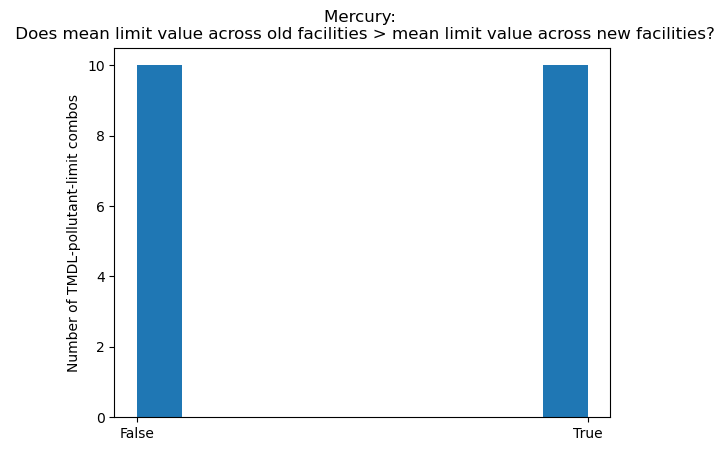

In [176]:
plt.style.use('default')
plt.title('Mercury: \n Does mean limit value across old facilities > mean limit value across new facilities?');
plt.ylabel('Number of TMDL-pollutant-limit combos')
plt.hist(list(map(str, results['Old_facility_limit_mean']>results['New_facility_limit_mean'])));